# Vehicle image classification

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


* import libraries

In [1]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Add, Activation, Flatten, Dense, Dropout, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16, ResNet50, Xception
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential, Model, load_model
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical, plot_model
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from google.colab.patches import cv2_imshow
from tensorflow.keras import regularizers
from collections import defaultdict
import matplotlib.pyplot as plt
import torch.nn as nn
import seaborn as sns
import pandas as pd
import visualkeras
import numpy as np
import torch
import glob
import cv2
import os

* Count the number of images in dataset and each class

In [ ]:
# Đường dẫn tới thư mục chứa các thư mục lớp
data_dir = "/content/drive/MyDrive/Deep/Deep-Data/Data"
total = 0

# Tạo một dict để lưu trữ số lượng ảnh trong từng lớp
class_counts = defaultdict(int)

# Lặp qua các thư mục lớp
for class_folder in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_folder)

    # Kiểm tra xem class_folder có phải là thư mục không
    if os.path.isdir(class_path):
        # Đếm số lượng ảnh trong thư mục lớp
        file_count = len(os.listdir(class_path))

        # Lưu số lượng ảnh vào dict
        class_counts[class_folder] = file_count

# In số lượng ảnh trong từng lớp
for class_folder, count in class_counts.items():
    print(f"Lớp {class_folder}: {count} ảnh")
    total += count

print(f'Tổng cộng dữ liệu có tất cả {total} ảnh')

Lớp Bicycle: 502 ảnh
Lớp Bus: 500 ảnh
Lớp Car: 502 ảnh
Lớp Moto: 501 ảnh
Lớp Truck: 500 ảnh
Tổng cộng dữ liệu có tất cả 2505 ảnh



* Label images data

In [ ]:
data_dir = "/content/drive/MyDrive/Deep/Deep-Data/Data"
class_names = ['Bicycle', 'Bus', 'Car', 'Moto', 'Truck']
c=0

X = []  # danh sách lưu trữ các ảnh
y = []  # danh sách lưu trữ các nhãn

for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path)
        X.append(img)
        y.append(class_name)
        print(c)
        c=c+1

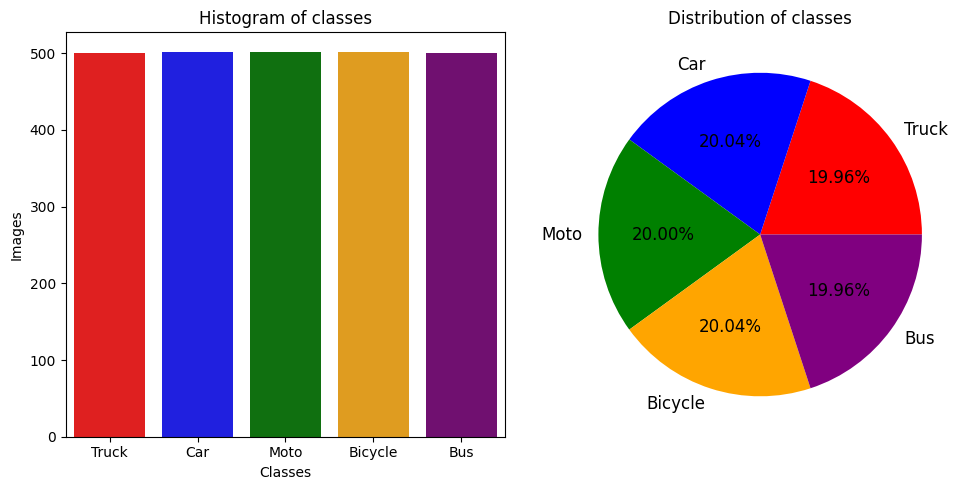

In [ ]:
# Define colors for each bar
bar_colors = ['red', 'blue', 'green', 'orange', 'purple']

# Count the occurrences of each class
class_counts = [y.count(c) for c in set(y)]

# Create the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Bar chart
sns.barplot(x=list(set(y)), y=class_counts, palette=bar_colors, ax=ax1)
ax1.set_title('Histogram of classes')
ax1.set_xlabel('Classes')
ax1.set_ylabel('Images')

# Pie chart
pie_colors = sns.color_palette(bar_colors)
ax2.pie(class_counts, labels=list(set(y)), colors=pie_colors, autopct='%1.2f%%', textprops={'fontsize': 12})
ax2.set_title('Distribution of classes')


# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

In [ ]:
X = np.array(X)

y = np.array(y)
# Khởi tạo LabelEncoder
label_encoder = LabelEncoder()

# Chuyển đổi các nhãn sang dạng số nguyên
y = label_encoder.fit_transform(y)

print('X size:', X.shape)
print('y size:', y.shape)


# Lưu trữ X và y vào tệp tin nhị phân
np.savez("/content/drive/MyDrive/Deep/Deep-Data/data.npz", X=X, y=y)

X size: (2505, 224, 224, 3)
y size: (2505,)


In [2]:
data = np.load("/content/drive/MyDrive/Deep/Deep-Data/data.npz")
X_train,X_test, y_train,y_test = train_test_split(data['X']/255,data['y'],test_size = 0.2, random_state = 2206)
X_train, X_valid = X_train[0:1600,:],X_train[1600:,:]
y_train, y_valid = y_train[0:1600],y_train[1600:]
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
y_test = to_categorical(y_test)
print('X train size:', X_train.shape)
print('y train size:', y_train.shape)
print('X valid size:', X_valid.shape)
print('y valid size:', y_valid.shape)
print('X test size:', X_test.shape)
print('y test size:', y_test.shape)

X train size: (1600, 224, 224, 3)
y train size: (1600, 5)
X valid size: (404, 224, 224, 3)
y valid size: (404, 5)
X test size: (501, 224, 224, 3)
y test size: (501, 5)


In [ ]:
# Set the random seed for reproducibility (optional)
np.random.seed(11)

# Randomly select 10 indices from X_train
random_indices = np.random.choice(len(X_train), size=15, replace=False)

# Create a subplot grid with 2 rows and 5 columns
fig, axes = plt.subplots(3, 5, figsize=(24, 12))

# Iterate over the randomly selected indices and plot the corresponding images
for i, ax in enumerate(axes.flat):
    image = X_train[random_indices[i]]*255
    image = image.astype(np.uint8)  # Convert to 8-bit unsigned integer
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    ax.imshow(image_rgb)
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Transfer Learning

**VGG-16**

In [5]:
# Tải mô hình VGG16 đã được huấn luyện trên ImageNet
pretrained_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Đóng băng các layer convolutional của mô hình
for layer in pretrained_model.layers:
    layer.trainable = False

# Tạo mô hình mới dựa trên mô hình VGG16 đã được đóng băng
vgg16_model = Sequential()
vgg16_model.add(pretrained_model)

# Thêm các layer phân loại vào cuối mô hình
vgg16_model.add(Flatten())
vgg16_model.add(Dense(256, activation='relu'))
vgg16_model.add(Dense(5, activation='softmax'))


vgg16_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422784   
                                                                 
 dense_3 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 21138757 (80.64 MB)
Trainable params: 6424069 (24.51 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


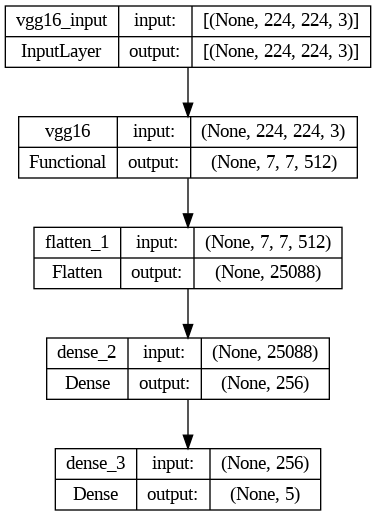

In [15]:
plot_model(vgg16_model, show_shapes=True)

Epoch 1/10
16/16 - 32s - loss: 3.4898 - accuracy: 0.5194 - val_loss: 0.9400 - val_accuracy: 0.7822 - 32s/epoch - 2s/step
Epoch 2/10
16/16 - 9s - loss: 0.4449 - accuracy: 0.8669 - val_loss: 0.4400 - val_accuracy: 0.8614 - 9s/epoch - 556ms/step
Epoch 3/10
16/16 - 8s - loss: 0.1765 - accuracy: 0.9344 - val_loss: 0.3045 - val_accuracy: 0.8960 - 8s/epoch - 505ms/step
Epoch 4/10
16/16 - 9s - loss: 0.0912 - accuracy: 0.9725 - val_loss: 0.3141 - val_accuracy: 0.8861 - 9s/epoch - 560ms/step
Epoch 5/10
16/16 - 9s - loss: 0.0537 - accuracy: 0.9887 - val_loss: 0.2599 - val_accuracy: 0.9233 - 9s/epoch - 566ms/step
Epoch 6/10
16/16 - 9s - loss: 0.0357 - accuracy: 0.9944 - val_loss: 0.2627 - val_accuracy: 0.9010 - 9s/epoch - 571ms/step
Epoch 7/10
16/16 - 9s - loss: 0.0256 - accuracy: 1.0000 - val_loss: 0.2480 - val_accuracy: 0.9208 - 9s/epoch - 570ms/step
Epoch 8/10
16/16 - 8s - loss: 0.0186 - accuracy: 1.0000 - val_loss: 0.2528 - val_accuracy: 0.9183 - 8s/epoch - 529ms/step
Epoch 9/10
16/16 - 9s - l

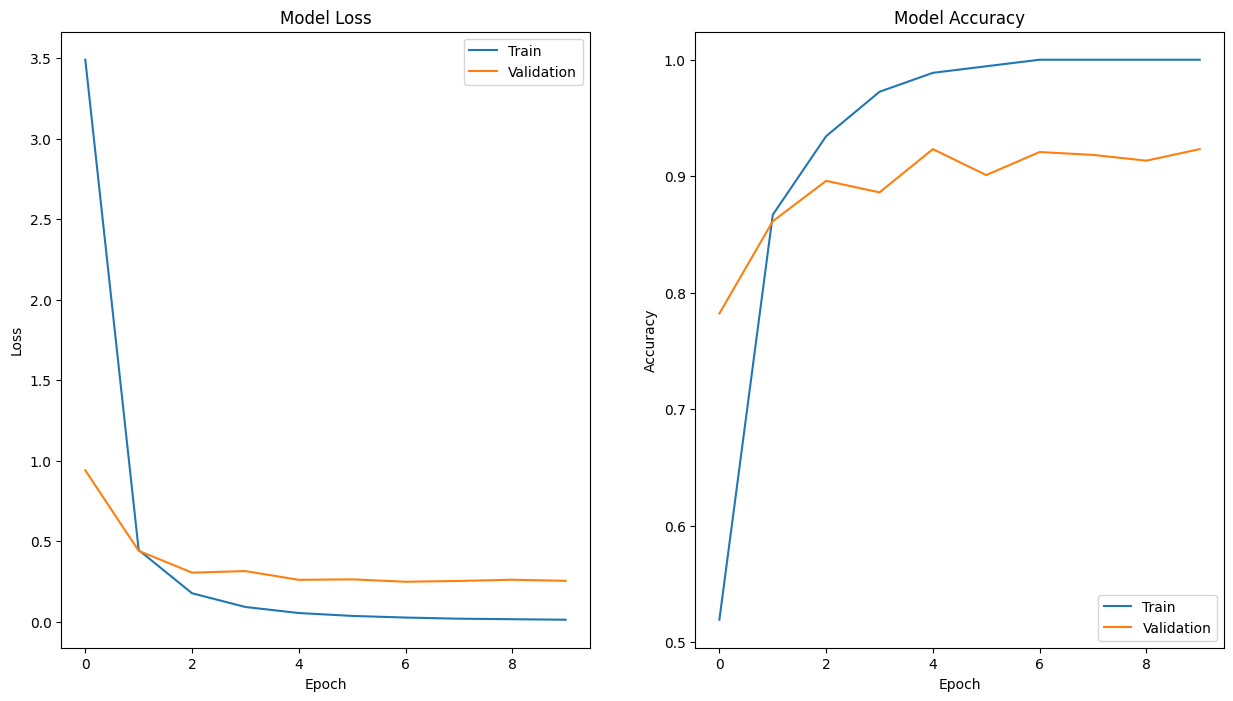

In [6]:
# Compile mô hình
vgg16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

hist = vgg16_model.fit(X_train, y_train,validation_data=(X_valid, y_valid),batch_size=100 ,epochs=10, verbose=2, shuffle=True)

# Vẽ biểu đồ huấn luyện
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

ax[0].plot(hist.history['loss'])
ax[0].plot(hist.history['val_loss'])
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper right')

ax[1].plot(hist.history['accuracy'])
ax[1].plot(hist.history['val_accuracy'])
ax[1].set_title('Model Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='lower right')

plt.show()

16/16 [==============================] - 2s 123ms/step
[[102   3   0   3   1]
 [  1  90   0   0  13]
 [  0   2  95   2   2]
 [  1   0   3  87   4]
 [  0   8   7   1  76]]


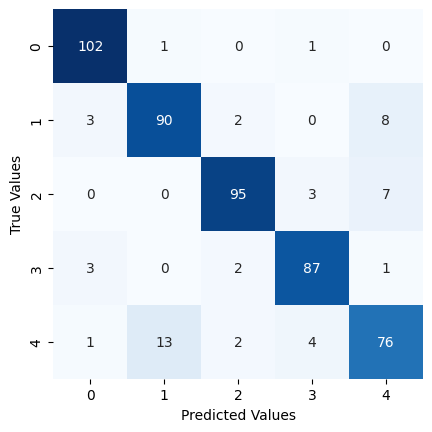

In [19]:
# Confusion matrix
y_pred = vgg16_model.predict(X_test)

# Chuyển đổi đầu ra đa nhãn thành nhãn nhị phân
y_pred_binary = np.argmax(y_pred, axis=1)
y_test_binary = np.argmax(y_test, axis=1)

# Tính toán confusion matrix
mat = confusion_matrix(y_test_binary, y_pred_binary)
print(mat)

# Vẽ confusion matrix
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.0f')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.show()

In [23]:
target_names = ['0', '1', '2', '3', '4']
print(classification_report(y_test_binary, y_pred_binary, target_names=target_names))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       109
           1       0.87      0.87      0.87       104
           2       0.90      0.94      0.92       101
           3       0.94      0.92      0.93        95
           4       0.79      0.83      0.81        92

    accuracy                           0.90       501
   macro avg       0.90      0.90      0.90       501
weighted avg       0.90      0.90      0.90       501



In [ ]:
# Load mô hình tốt nhất trong file Cifar10-FirstCNN-valid.keras
score = vgg16_model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.9205426573753357


**Xception**

In [25]:
# Tải mô hình Xception đã được huấn luyện trên ImageNet
pretrained_xception_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Đóng băng các layer convolutional của mô hình
for layer in pretrained_xception_model.layers:
    layer.trainable = False

# Tạo mô hình mới dựa trên mô hình Xception đã được đóng băng
xception_model = Sequential()
xception_model.add(pretrained_xception_model)

# Thêm các layer phân loại vào cuối mô hình
xception_model.add(Flatten())

# Thêm Dropout
xception_model.add(Dropout(0.2))  # Sử dụng Dropout với tỷ lệ 0.2

# Thêm Dense với Regularization
xception_model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # Sử dụng L2 Regularization với hệ số 0.01

# Thêm Dropout tiếp
xception_model.add(Dropout(0.2))  # Sử dụng Dropout với tỷ lệ 0.2

xception_model.add(Dense(5, activation='softmax'))

# Compile mô hình
xception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

xception_model.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dropout (Dropout)           (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 256)               25690368  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 5)                 1285      
                                                       

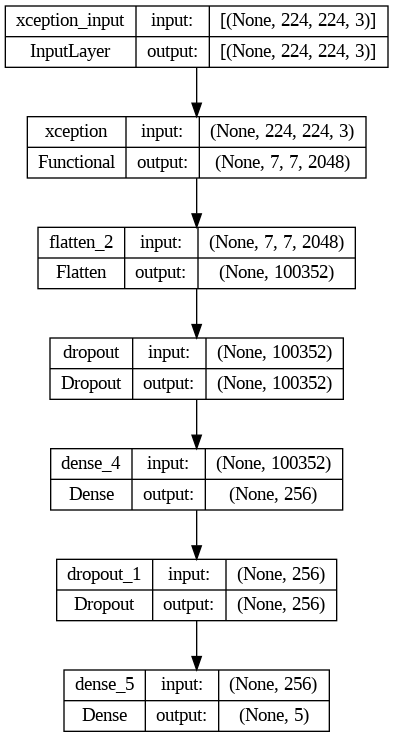

In [26]:
plot_model(xception_model, show_shapes=True)

Epoch 1/10
16/16 - 20s - loss: 3.4382 - accuracy: 0.8456 - val_loss: 3.3954 - val_accuracy: 0.9010 - 20s/epoch - 1s/step
Epoch 2/10
16/16 - 9s - loss: 2.6946 - accuracy: 0.9500 - val_loss: 3.1566 - val_accuracy: 0.8936 - 9s/epoch - 542ms/step
Epoch 3/10
16/16 - 10s - loss: 2.1312 - accuracy: 0.9700 - val_loss: 2.5136 - val_accuracy: 0.9134 - 10s/epoch - 608ms/step
Epoch 4/10
16/16 - 10s - loss: 1.6687 - accuracy: 0.9750 - val_loss: 2.2601 - val_accuracy: 0.9134 - 10s/epoch - 599ms/step
Epoch 5/10
16/16 - 9s - loss: 1.4187 - accuracy: 0.9812 - val_loss: 1.7733 - val_accuracy: 0.9208 - 9s/epoch - 539ms/step
Epoch 6/10
16/16 - 9s - loss: 1.2350 - accuracy: 0.9775 - val_loss: 1.6723 - val_accuracy: 0.9059 - 9s/epoch - 579ms/step
Epoch 7/10
16/16 - 9s - loss: 0.9267 - accuracy: 0.9856 - val_loss: 1.3375 - val_accuracy: 0.9233 - 9s/epoch - 576ms/step
Epoch 8/10
16/16 - 9s - loss: 0.6738 - accuracy: 0.9887 - val_loss: 0.9605 - val_accuracy: 0.9158 - 9s/epoch - 576ms/step
Epoch 9/10
16/16 - 9s

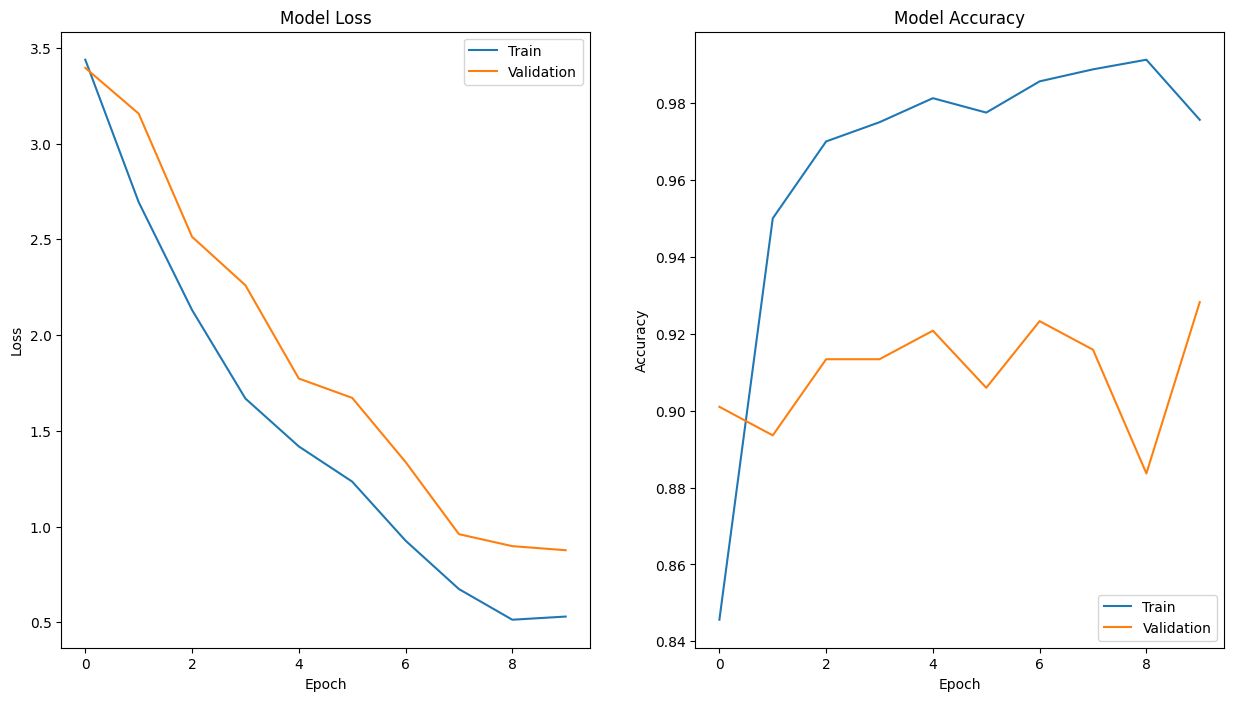

In [28]:
# Compile mô hình
xception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

hist = xception_model.fit(X_train, y_train,validation_data=(X_valid, y_valid),batch_size=100 ,epochs=10, verbose=2, shuffle=True)

# Vẽ biểu đồ huấn luyện
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

ax[0].plot(hist.history['loss'])
ax[0].plot(hist.history['val_loss'])
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper right')

ax[1].plot(hist.history['accuracy'])
ax[1].plot(hist.history['val_accuracy'])
ax[1].set_title('Model Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='lower right')

plt.show()

16/16 [==============================] - 2s 140ms/step
[[103   2   0   3   1]
 [  2  89   1   1  11]
 [  0   0  96   3   2]
 [  1   0   0  93   1]
 [  1   3   3   0  85]]


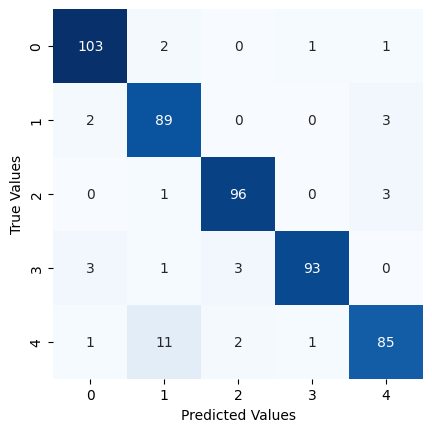

In [32]:
# Confusion matrix
y_pred = xception_model.predict(X_test)

# Chuyển đổi đầu ra đa nhãn thành nhãn nhị phân
y_pred_binary = np.argmax(y_pred, axis=1)
y_test_binary = np.argmax(y_test, axis=1)

# Tính toán confusion matrix
mat = confusion_matrix(y_test_binary, y_pred_binary)
print(mat)

# Vẽ confusion matrix
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.0f')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.show()

In [33]:
target_names = ['0', '1', '2', '3', '4']
print(classification_report(y_test_binary, y_pred_binary, target_names=target_names))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       109
           1       0.95      0.86      0.90       104
           2       0.96      0.95      0.96       101
           3       0.93      0.98      0.95        95
           4       0.85      0.92      0.89        92

    accuracy                           0.93       501
   macro avg       0.93      0.93      0.93       501
weighted avg       0.93      0.93      0.93       501



# My Model

In [1]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Add, Activation, Flatten, Dense, Dropout, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16, ResNet50, Xception
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential, Model, load_model
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical, plot_model
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from google.colab.patches import cv2_imshow
from tensorflow.keras import regularizers
from collections import defaultdict
import matplotlib.pyplot as plt
import torch.nn as nn
import seaborn as sns
import pandas as pd
import visualkeras
import numpy as np
import torch
import glob
import cv2
import os

In [2]:
data = np.load("/content/drive/MyDrive/Deep/Deep-Data/data.npz")
X_train,X_test, y_train,y_test = train_test_split(data['X']/255,data['y'],test_size = 0.2, random_state = 2206)
X_train, X_valid = X_train[0:1600,:],X_train[1600:,:]
y_train, y_valid = y_train[0:1600],y_train[1600:]
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
y_test = to_categorical(y_test)
print('X train size:', X_train.shape)
print('y train size:', y_train.shape)
print('X valid size:', X_valid.shape)
print('y valid size:', y_valid.shape)
print('X test size:', X_test.shape)
print('y test size:', y_test.shape)

X train size: (1600, 224, 224, 3)
y train size: (1600, 5)
X valid size: (404, 224, 224, 3)
y valid size: (404, 5)
X test size: (501, 224, 224, 3)
y test size: (501, 5)


In [3]:
# Define the model
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output
model.add(Flatten())

# Add fully connected layers
model.add(Dense(128, activation='relu'))

model.add(Dense(5, activation='softmax'))


# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

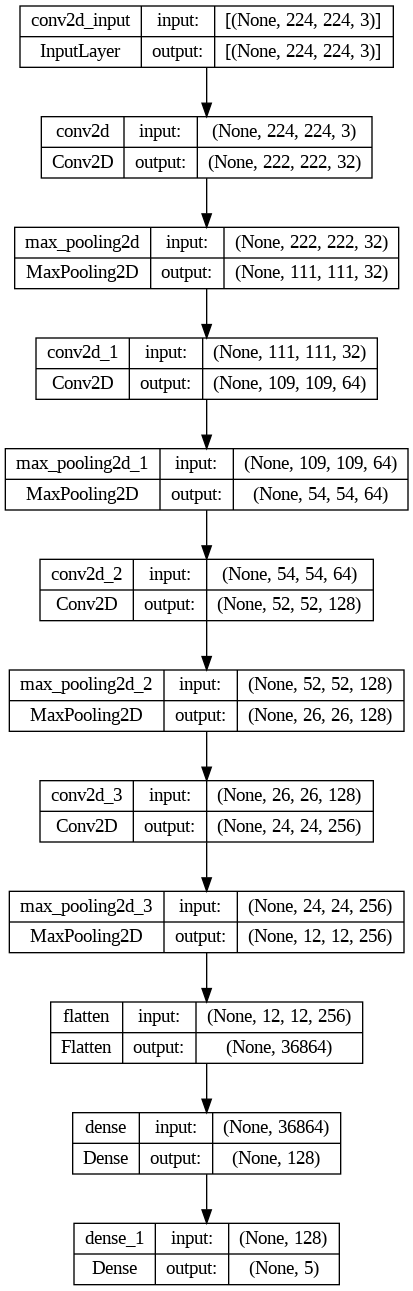

In [4]:
plot_model(model, show_shapes=True)

Epoch 1/20
4/4 - 36s - loss: 1.6813 - accuracy: 0.2494 - val_loss: 1.5433 - val_accuracy: 0.2698 - 36s/epoch - 9s/step
Epoch 2/20
4/4 - 3s - loss: 1.4765 - accuracy: 0.3306 - val_loss: 1.3240 - val_accuracy: 0.4678 - 3s/epoch - 723ms/step
Epoch 3/20
4/4 - 3s - loss: 1.2518 - accuracy: 0.5100 - val_loss: 1.2057 - val_accuracy: 0.5421 - 3s/epoch - 763ms/step
Epoch 4/20
4/4 - 3s - loss: 1.1238 - accuracy: 0.5956 - val_loss: 1.1754 - val_accuracy: 0.6213 - 3s/epoch - 757ms/step
Epoch 5/20
4/4 - 3s - loss: 1.0385 - accuracy: 0.6375 - val_loss: 0.9677 - val_accuracy: 0.6584 - 3s/epoch - 762ms/step
Epoch 6/20
4/4 - 3s - loss: 0.8750 - accuracy: 0.7044 - val_loss: 0.9799 - val_accuracy: 0.6634 - 3s/epoch - 768ms/step
Epoch 7/20
4/4 - 3s - loss: 0.8329 - accuracy: 0.7106 - val_loss: 0.8520 - val_accuracy: 0.7252 - 3s/epoch - 821ms/step
Epoch 8/20
4/4 - 3s - loss: 0.7214 - accuracy: 0.7437 - val_loss: 0.8229 - val_accuracy: 0.7376 - 3s/epoch - 768ms/step
Epoch 9/20
4/4 - 3s - loss: 0.6832 - accu

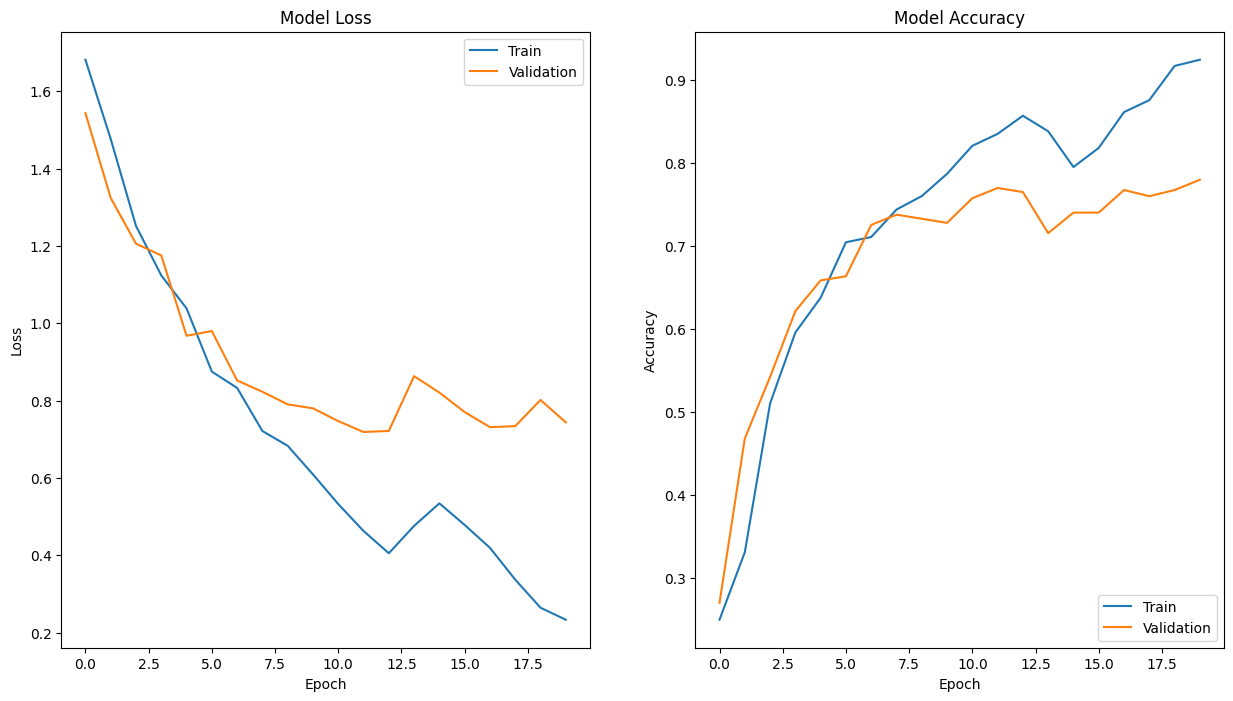

In [5]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
hist = model.fit(X_train, y_train,validation_data=(X_valid, y_valid),batch_size=500 ,epochs=20, verbose=2, shuffle=True)
model.save('/content/drive/MyDrive/Model.keras')
# END CODE8
# Vẽ biểu đồ huấn luyện
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

ax[0].plot(hist.history['loss'])
ax[0].plot(hist.history['val_loss'])
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper right')

ax[1].plot(hist.history['accuracy'])
ax[1].plot(hist.history['val_accuracy'])
ax[1].set_title('Model Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='lower right')

plt.show()

16/16 [==============================] - 2s 52ms/step
[[90  0  0  7 12]
 [ 6 75  7  1 15]
 [ 2  7 77  8  7]
 [ 6  0  5 75  9]
 [ 8  1  8  5 70]]


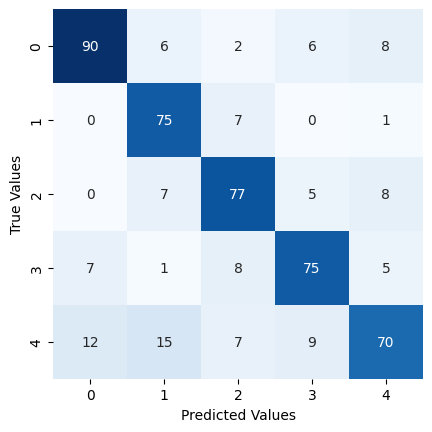

In [6]:
# Confusion matrix
y_pred = model.predict(X_test)

# Chuyển đổi đầu ra đa nhãn thành nhãn nhị phân
y_pred_binary = np.argmax(y_pred, axis=1)
y_test_binary = np.argmax(y_test, axis=1)

# Tính toán confusion matrix
mat = confusion_matrix(y_test_binary, y_pred_binary)
print(mat)

# Vẽ confusion matrix
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.0f')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.show()

In [7]:
target_names = ['0', '1', '2', '3', '4']
print(classification_report(y_test_binary, y_pred_binary, target_names=target_names))

              precision    recall  f1-score   support

           0       0.80      0.83      0.81       109
           1       0.90      0.72      0.80       104
           2       0.79      0.76      0.78       101
           3       0.78      0.79      0.79        95
           4       0.62      0.76      0.68        92

    accuracy                           0.77       501
   macro avg       0.78      0.77      0.77       501
weighted avg       0.78      0.77      0.77       501



In [ ]:
model = load_model('/content/drive/MyDrive/HM_Model.keras')

In [ ]:
def preprocess_new_image(image):
    # Resize the image to match the input size of the model (e.g., 224x224)
    resized_image = cv2.resize(image, (224, 224))

    # Convert the image to float32 data type
    resized_image = resized_image.astype(np.float32)

    # Apply any necessary normalization or channel reordering
    # For example, if the model expects RGB images, you can convert BGR to RGB:
    rgb_image = resized_image[:, :, ::-1]  # Convert BGR to RGB

    # Normalize the pixel values
    normalized_image = rgb_image / 255.0

    # Add an extra dimension to represent the batch size (1 in this case)
    preprocessed_image = np.expand_dims(normalized_image, axis=0)

    return preprocessed_image

def get_class_name(prediction):
    classes = ['Bicycle', 'Bus', 'Car', 'Moto', 'Truck']
    class_index = np.argmax(prediction)
    return classes[class_index]

1/1 [==============================] - 1s 525ms/step


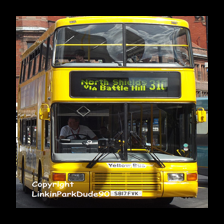


This is: Bus


In [ ]:

img = cv2.imread('/content/drive/MyDrive/Deep/Deep-Data/Data/Bus/1105.png')
im = preprocess_new_image(img)
pred = get_class_name(model.predict(im))
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()
print('\nThis is:', pred)